In [1]:
%matplotlib notebook
import control as c
import ipywidgets as w
import numpy as np

from IPython.display import display, HTML
import matplotlib.pyplot as plt
import matplotlib.animation as animation

display(HTML('<script> $(document).ready(function() { $("div.input").hide(); }); </script>'))

## Controllo di un sistema del secondo ordine con PID discreto

Nell'esempio seguente, esploreremo l'effetto del campionamento a tempo discreto su un sistema del secondo ordine, sottormorzato, controllato da un controller PID. Il controller PID è progettato e calibrato con parametri a tempo continuo, viene quindi convertito in tempo discreto da un mantenitore di ordine zero (ZOH) o con la tecnica del "pole matching". Il segnale del controller viene riportato a tempo continuo utilizzando un secondo ZOH.

<br>
$$G(s)=\frac{1}{s^2+2R_es+(R_e+I_m j)\cdot(R_e-I_m j)}$$
<br>
<img src="Images/discrete.png" width="40%" />
<br>
<b>Scegli i poli del sistema e un tempo di campionamento per la discretizzazione!</b>

<IPython.core.display.Javascript object>


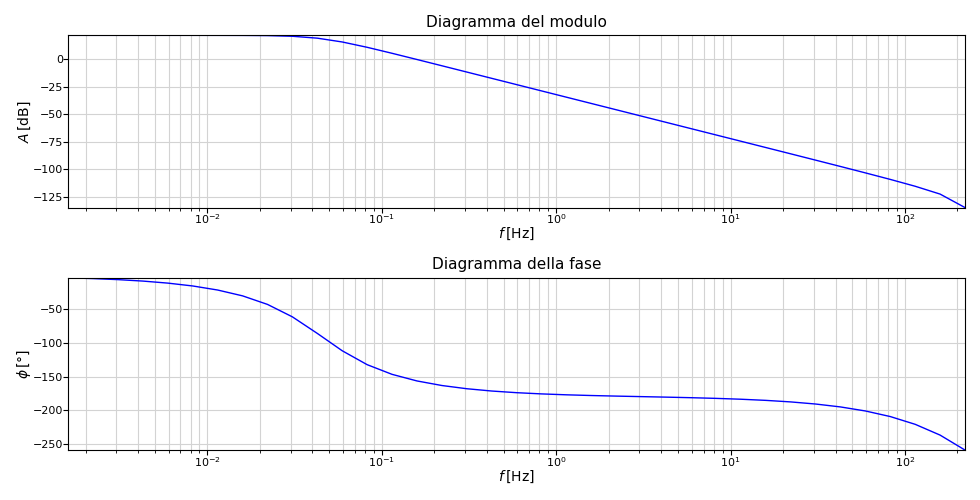

Output()

In [2]:
# Figure definition

fig1, ((f1_ax1), (f1_ax2)) = plt.subplots(2, 1)
fig1.set_size_inches((9.8, 5))
fig1.set_tight_layout(True)

f1_line1, = f1_ax1.plot([], [])
f1_line2, = f1_ax2.plot([], [])  

f1_ax1.grid(which='both', axis='both', color='lightgray')
f1_ax2.grid(which='both', axis='both', color='lightgray')

f1_ax1.autoscale(enable=True, axis='both', tight=True)
f1_ax2.autoscale(enable=True, axis='both', tight=True)

f1_ax1.set_title('Diagramma del modulo', fontsize=11)
f1_ax1.set_xscale('log')
f1_ax1.set_xlabel(r'$f\/$[Hz]', labelpad=0, fontsize=10)
f1_ax1.set_ylabel(r'$A\/$[dB]', labelpad=0, fontsize=10)
f1_ax1.tick_params(axis='both', which='both', pad=0, labelsize=8)

f1_ax2.set_title('Diagramma della fase', fontsize=11)
f1_ax2.set_xscale('log')
f1_ax2.set_xlabel(r'$f\/$[Hz]', labelpad=0, fontsize=10)
f1_ax2.set_ylabel(r'$\phi\/$[°]', labelpad=0, fontsize=10)
f1_ax2.tick_params(axis='both', which='both', pad=0, labelsize=8)   


# System model

def system_model(Im, Re, dts):

    W_syscont = c.tf([1], [1, 2*Re, (Re+Im*1j)*(Re-Im*1j)])
    W_sys = c.sample_system(W_syscont, dts, method='zoh')
    # Zero Order Hold conversion to include continuous system in discrete model

    print('Funzione di trasferimento del sistema:')
    print(W_syscont)
    print('\nFunzione di trasferimento discretizzata:')
    print(W_sys)

    # System analysis

    poles_cont = c.pole(W_syscont)     # Poles
    poles = c.pole(W_sys)

    print('\nPoli del sistema:')
    print(poles_cont)
    print('\nPoli del sistema discretizzato:')
    print(poles)
    
    global f1_line1, f1_line2
    
    f1_ax1.lines.remove(f1_line1)
    f1_ax2.lines.remove(f1_line2)

    mag, phase, omega = c.bode_plot(W_sys, Plot=False)   # Bode-plot

    f1_line1, = f1_ax1.plot(omega/2/np.pi, 20*np.log10(mag), lw=1, color='blue')
    f1_line2, = f1_ax2.plot(omega/2/np.pi, phase*180/np.pi, lw=1, color='blue')   

    f1_ax1.relim()
    f1_ax2.relim()
    f1_ax1.autoscale_view()
    f1_ax2.autoscale_view()
    
# GUI widgets
    
Re_slider = w.FloatLogSlider(value=0.2, base=10, min=-4, max=1, description='Polo.Re (negativo) :', continuous_update=False,
                             layout=w.Layout(width='50%'), style={'description_width':'50%'})
Im_slider = w.FloatLogSlider(value=0.2, base=10, min=-4, max=1, description='Polo.Im :', continuous_update=False,
                             layout=w.Layout(width='50%'), style={'description_width':'30%'})
dts_slider = w.FloatLogSlider(value=0.002, base=10, min=-4, max=0, description='dts [s] :', continuous_update=False,
                                 layout=w.Layout(width='50%'))

input_data = w.interactive_output(system_model, {'Re':Re_slider, 'Im':Im_slider, 'dts':dts_slider})

display(w.HBox([Re_slider, Im_slider, dts_slider]), input_data)

Dopo aver osservato le caratteristiche del sistema, <b>scegli un tipo di controllore!<b>

In [3]:
#Controller type select

typeSelect = w.ToggleButtons(
    options=[('P (matched)', 0), ('PI (ZOH)', 1), ('PD (matched)', 2), ('PD Reale (ZOH)', 3), ('PID Reale (ZOH)', 4)],
    description='Controller: ', style={'description_width':'15%'})

display(typeSelect)

ToggleButtons(description='Controller: ', options=(('P (matched)', 0), ('PI (ZOH)', 1), ('PD (matched)', 2), (…

<b>Modifica i valori del controller in modo che il tempo di salita/assestamento, l'overshoot o l'errore rimanente siano minimi!</b><br>
Non è possibile ottenere i migliori risultati per ogni parametro in una singola configurazione. Crea più soluzioni, una per ogni tipo!

<IPython.core.display.Javascript object>


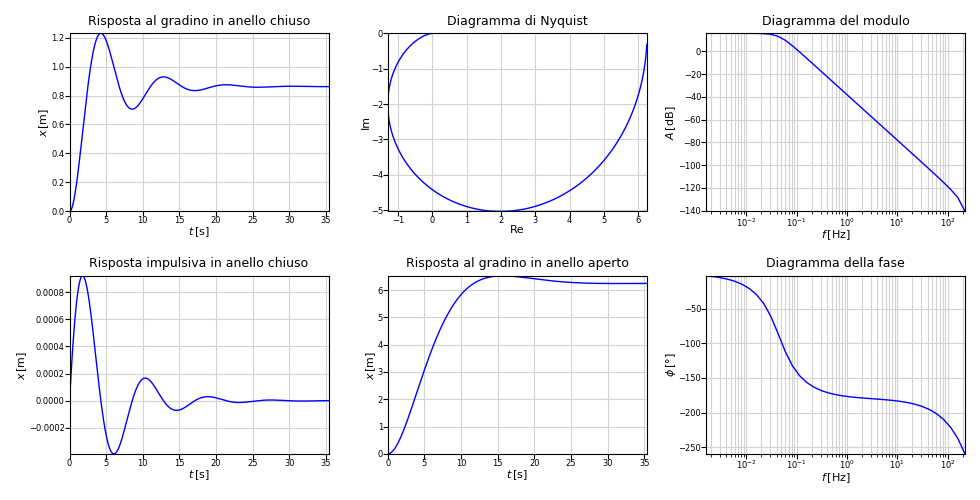

Output()

In [4]:
# PID control

# Figure definition
fig2, ((f2_ax1, f2_ax2, f2_ax3), (f2_ax4, f2_ax5, f2_ax6)) = plt.subplots(2, 3)
fig2.set_size_inches((9.8, 5))
fig2.set_tight_layout(True)

f2_line1, = f2_ax1.plot([], [])
f2_line2, = f2_ax2.plot([], []) 
f2_line3, = f2_ax3.plot([], [])
f2_line4, = f2_ax4.plot([], [])  
f2_line5, = f2_ax5.plot([], [])
f2_line6, = f2_ax6.plot([], [])

f2_ax1.grid(which='both', axis='both', color='lightgray')
f2_ax2.grid(which='both', axis='both', color='lightgray')
f2_ax3.grid(which='both', axis='both', color='lightgray')
f2_ax4.grid(which='both', axis='both', color='lightgray')
f2_ax5.grid(which='both', axis='both', color='lightgray')
f2_ax6.grid(which='both', axis='both', color='lightgray')

f2_ax1.autoscale(enable=True, axis='both', tight=True)
f2_ax2.autoscale(enable=True, axis='both', tight=True)
f2_ax3.autoscale(enable=True, axis='both', tight=True)
f2_ax4.autoscale(enable=True, axis='both', tight=True)
f2_ax5.autoscale(enable=True, axis='both', tight=True)
f2_ax6.autoscale(enable=True, axis='both', tight=True)

f2_ax1.set_title('Risposta al gradino in anello chiuso', fontsize=9)
f2_ax1.set_xlabel(r'$t\/$[s]', labelpad=0, fontsize=8)
f2_ax1.set_ylabel(r'$x\/$[m]', labelpad=0, fontsize=8)
f2_ax1.tick_params(axis='both', which='both', pad=0, labelsize=6)

f2_ax2.set_title('Diagramma di Nyquist', fontsize=9)
f2_ax2.set_xlabel(r'Re', labelpad=0, fontsize=8)
f2_ax2.set_ylabel(r'Im', labelpad=0, fontsize=8)
f2_ax2.tick_params(axis='both', which='both', pad=0, labelsize=6)

f2_ax3.set_title('Diagramma del modulo', fontsize=9)
f2_ax3.set_xscale('log')
f2_ax3.set_xlabel(r'$f\/$[Hz]', labelpad=0, fontsize=8)
f2_ax3.set_ylabel(r'$A\/$[dB]', labelpad=0, fontsize=8)
f2_ax3.tick_params(axis='both', which='both', pad=0, labelsize=6)

f2_ax4.set_title('Risposta impulsiva in anello chiuso', fontsize=9)
f2_ax4.set_xlabel(r'$t\/$[s]', labelpad=0, fontsize=8)
f2_ax4.set_ylabel(r'$x\/$[m]', labelpad=0, fontsize=8)
f2_ax4.tick_params(axis='both', which='both', pad=0, labelsize=6)

f2_ax5.set_title('Risposta al gradino in anello aperto', fontsize=9)
f2_ax5.set_xlabel(r'$t\/$[s]', labelpad=0, fontsize=8)
f2_ax5.set_ylabel(r'$x\/$[m]', labelpad=0, fontsize=8)
f2_ax5.tick_params(axis='both', which='both', pad=0, labelsize=6)

f2_ax6.set_title('Diagramma della fase', fontsize=9)
f2_ax6.set_xscale('log')
f2_ax6.set_xlabel(r'$f\/$[Hz]', labelpad=0, fontsize=8)
f2_ax6.set_ylabel(r'$\phi\/$[°]', labelpad=0, fontsize=8)
f2_ax6.tick_params(axis='both', which='both', pad=0, labelsize=6)

def pid_control(Kp, Ti, Td, Fd, type_select, Im, Re, dts):
    
    W_syscont = c.tf([1], [1, 2*Re, (Re+Im*1j)*(Re-Im*1j)])
    W_sys = c.sample_system(W_syscont, dts, method='zoh')
    # Zero Order Hold conversion to include continuous system in discrete model
    
    if type_select in (1, 4):
        Ti0 = 1
    else:
        Ti0 = 0
        
    if type_select in (2, 3, 4):
        Td0 = 1
    else :
        Td0 = 0
        
    if type_select in (3, 4):
        Fd0 = 1
    else:
        Fd0 = 0
    
    if type_select in (0, 2):
        convmet = "matched"
    else:
        convmet = "zoh"
    
    # PID Controller
    
    P = Kp             # Proportional term
    I = Kp / Ti        # Integral term
    D = Kp * Td        # Derivative term
    Td_f = Td / Fd     # Derivative term filter
    
    W_PID_cont = c.parallel(c.tf([P], [1]),
                            c.tf([I * Ti0], [1 * Ti0, 1 * (not Ti0)]),
                            c.tf([D * Td0, 0], [Td_f * Td0 * Fd0, 1]))  # PID controller in time constant format    
    
    W_PID = c.sample_system(W_PID_cont, dts, method=convmet) # PID discretization
    
    W_open = c.series(W_PID, W_sys)      # Open loop
    W_closed = c.feedback(W_open, 1, -1)    # Closed loop with negative feedback
    
    # Display
                        
    global f2_line1, f2_line2, f2_line3, f2_line4, f2_line5, f2_line6

    try:
        f2_ax1.lines.remove(f2_line1)
        f2_ax2.lines.remove(f2_line2)
        f2_ax3.lines.remove(f2_line3)
        f2_ax4.lines.remove(f2_line4)
        f2_ax5.lines.remove(f2_line5)
        f2_ax6.lines.remove(f2_line6)
    except:
        pass
    
    tin = np.arange(0, 10/abs(Re+Im*1j), dts)

    if tin.size > 1:
    
        tout, yout = c.step_response(W_closed, tin)
        maxint = min(tout.size, yout.size)
        f2_line1, = f2_ax1.plot(tout[0:maxint], yout[0:maxint], lw=1, color='blue')

        _, _, ob = c.nyquist_plot(W_open, Plot=False)   # Small resolution plot to determine bounds        
        real, imag, freq = c.nyquist_plot(W_open, omega=np.logspace(np.log10(ob[0]), np.log10(ob[-1]), 1000), Plot=False)
        f2_line2, = f2_ax2.plot(real, imag, lw=1, color='blue')

        mag, phase, omega = c.bode_plot(W_open, Plot=False)
        f2_line3, = f2_ax3.plot(omega/2/np.pi, 20*np.log10(mag), lw=1, color='blue')
        f2_line6, = f2_ax6.plot(omega/2/np.pi, phase*180/np.pi, lw=1, color='blue')

        tout, yout = c.impulse_response(W_closed, tin)
        maxint = min(tout.size, yout.size)
        f2_line4, = f2_ax4.plot(tout[0:maxint], yout[0:maxint], lw=1, color='blue')

        tout, yout = c.step_response(W_open, tin)
        maxint = min(tout.size, yout.size)
        f2_line5, = f2_ax5.plot(tout[0:maxint], yout[0:maxint], lw=1, color='blue')

    f2_ax1.relim()
    f2_ax2.relim()
    f2_ax3.relim()
    f2_ax4.relim()
    f2_ax5.relim()
    f2_ax6.relim()

    f2_ax1.autoscale_view()
    f2_ax2.autoscale_view()
    f2_ax3.autoscale_view()
    f2_ax4.autoscale_view()
    f2_ax5.autoscale_view()
    f2_ax6.autoscale_view()
    
# GUI widgets

def draw_controllers(type_select):
    
    global Kp_slider
    global Ti_slider
    global Td_slider
    global Fd_slider
    
    Kp_slider = w.FloatLogSlider(value=0.5, base=10, min=-1, max=4, description='Kp:', continuous_update=False,
                                 layout=w.Layout(width='auto', flex='5 5 auto'))
    
    if type_select in (1, 4):
        Ti_slider = w.FloatLogSlider(value=0.0035, base=10, min=-4, max=1, description='Ti:', continuous_update=False,
                                     layout=w.Layout(width='auto', flex='5 5 auto'))
    else:
        Ti_slider = w.FloatLogSlider(value=0.0035, base=10, min=-4, max=1, description='Ti:', continuous_update=False,
                                     layout=w.Layout(width='auto', flex='5 5 auto'), disabled=True)
        
    if type_select in (2, 3, 4):
        Td_slider = w.FloatLogSlider(value=1, base=10, min=-4, max=1, description='Td:', continuous_update=False,
                                     layout=w.Layout(width='auto', flex='5 5 auto'))
    else:
        Td_slider = w.FloatLogSlider(value=1, base=10, min=-4, max=1, description='Td:', continuous_update=False,
                                     layout=w.Layout(width='auto', flex='5 5 auto'), disabled=True)
    
    if type_select in (3, 4):
        Fd_slider = w.FloatLogSlider(value=1, base=10, min=0, max=3, description='Fd:', continuous_update=False,
                                     layout=w.Layout(width='auto', flex='5 5 auto'))
    else:
        Fd_slider = w.FloatLogSlider(value=1, base=10, min=0, max=3, description='Fd:', continuous_update=False,
                                     layout=w.Layout(width='auto', flex='5 5 auto'), disabled=True)


    input_data = w.interactive_output(pid_control, {'Kp': Kp_slider, 'Ti': Ti_slider, 'Td': Td_slider,
                                      'Fd': Fd_slider, 'type_select': typeSelect,
                                      'Re': Re_slider, 'Im': Im_slider, 'dts': dts_slider})

    display(w.HBox([Kp_slider, Ti_slider, Td_slider, Fd_slider]), input_data)
    
w.interactive_output(draw_controllers, {'type_select':typeSelect})

È possibile testare le funzionalità di inseguimento del riferimento del sistema controllato utilizzando la simulazione.<br>
<b>Modifica il controller in modo che sia capace di seguire una sinusoide in modo accettabile!</b>

<IPython.core.display.Javascript object>


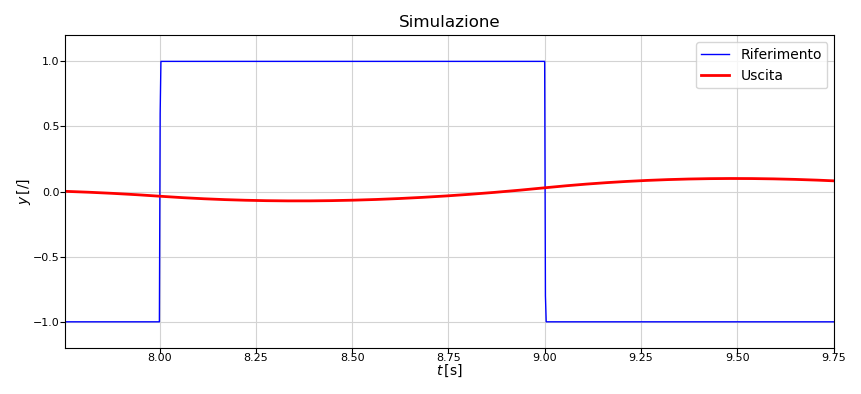

Output()

In [5]:
# Simulation data

anim_fig = plt.figure()
anim_fig.set_size_inches((9.8, 4))
anim_fig.set_tight_layout(True)

anim_ax1 = anim_fig.add_subplot(111)

frame_count=1000
scope_rounds=4

l1 = anim_ax1.plot([], [], lw=1, color='blue')
l2 = anim_ax1.plot([], [], lw=2, color='red')

line1 = l1[0]
line2 = l2[0]

anim_ax1.legend(l1+l2, ['Riferimento', 'Uscita'], loc=1)

anim_ax1.set_title('Simulazione', fontsize=12)
anim_ax1.set_xlabel(r'$t\/$[s]', labelpad=0, fontsize=10)
anim_ax1.set_ylabel(r'$y\/$[/]', labelpad=0, fontsize=10)
anim_ax1.tick_params(axis='both', which='both', pad=0, labelsize=8)

anim_ax1.grid(which='both', axis='both', color='lightgray')

T_plot = []
X_plot = []
R_plot = []

#Simulation function

def simulation(Kp, Ti, Td, Fd, type_select, Im, Re, dts, T, X, Xf, Xa):
    
    W_syscont = c.tf([1], [1, 2*Re, (Re+Im*1j)*(Re-Im*1j)])
    W_sys = c.sample_system(W_syscont, dts, method='zoh')
    # Zero Order Hold conversion to include continuous system in discrete model
    
    
    if type_select in (1, 4):
        Ti0 = 1
    else:
        Ti0 = 0
        
    if type_select in (2, 3, 4):
        Td0 = 1
    else :
        Td0 = 0
        
    if type_select in (3, 4):
        Fd0 = 1
    else:
        Fd0 = 0
    
    if type_select in (0, 2):
        convmet = "matched"
    else:
        convmet = "zoh"
    
    # Controller
    
    P = Kp             # Proportional term
    I = Kp / Ti        # Integral term
    D = Kp * Td        # Derivative term
    Td_f = Td * Fd     # Derivative term filter
    
    W_PID_cont = c.parallel(c.tf([P], [1]),
                            c.tf([I * Ti0], [1 * Ti0, 1 * (not Ti0)]),
                            c.tf([D * Td0, 0], [Td_f * Td0 * Fd0, 1]))  # PID controller in time constant format    
    
    # Model
    
    W_PID = c.sample_system(W_PID_cont, dts, method=convmet) # PID discretization
    W_open = c.series(W_PID, W_sys)      # Open loop
    W_closed = c.feedback(W_open, 1, -1)    # Closed loop with negative feedback
    
    # Reference and disturbance signals

    T_sim = np.arange(0, T, dts, dtype=np.float64)
    
    if X == 0:   # Sine wave reference
        X_sim = np.sin(2 * np.pi * Xf * T_sim) * Xa
    elif X == 1:   # Square wave reference
        X_sim = np.sign(np.sin(2 * np.pi * Xf * T_sim)) * Xa
    
    # System response
        
    Tx, youtx, xoutx = c.forced_response(W_closed, T_sim, X_sim)
    
    # Display
    
    XR_max = max(np.amax(np.absolute(np.concatenate((X_sim, youtx)))), Xa)
    if not np.isnan(XR_max):
        anim_ax1.set_ylim((-1.2 * XR_max, 1.2 * XR_max))
    
    global T_plot, X_plot, R_plot
    
    T_plot = np.linspace(0, T, frame_count*(scope_rounds+1), dtype=np.float32)
    X_plot = np.interp(T_plot, T_sim, X_sim)
    R_plot = np.interp(T_plot, T_sim, youtx)
        
def anim_init():
    line1.set_data([], [])
    line2.set_data([], [])
    anim_ax1.set_xlim((0, T_plot[frame_count-1]))
    
    return (line1, line2, anim_ax1,)

def animate(i):
    line1.set_data(T_plot[scope_rounds*i:scope_rounds*i+frame_count-1], X_plot[scope_rounds*i:scope_rounds*i+frame_count-1])
    line2.set_data(T_plot[scope_rounds*i:scope_rounds*i+frame_count-1], R_plot[scope_rounds*i:scope_rounds*i+frame_count-1])
    anim_ax1.set_xlim((T_plot[i*scope_rounds], T_plot[i*scope_rounds+frame_count-1]))
    
    return (line1, line2, anim_ax1,)

anim = animation.FuncAnimation(anim_fig, animate, init_func=anim_init,
                               frames=frame_count, interval=10, blit=True,
                               repeat=True)

# Controllers

T_slider = w.FloatLogSlider(value=10, base=10, min=-0.7, max=1, step=0.01,
                            description='Durata [s]:', continuous_update=False,
                            orientation='vertical', layout=w.Layout(width='auto', height='auto', flex='1 1 auto'))
       
X_type = w.Dropdown(options=[('Sinusoide', 0), ('Onda quadra', 1)], value=1,
                    description='Riferimento: ', continuous_update=False, layout=w.Layout(width='auto', flex='3 3 auto'))    
Xf_slider = w.FloatLogSlider(value=0.5, base=10, min=-2, max=2, step=0.01,
                             description='Frequenza [Hz]:', continuous_update=False,
                             orientation='vertical', layout=w.Layout(width='auto', height='auto', flex='1 1 auto'))
Xa_slider = w.FloatLogSlider(value=1, base=10, min=-2, max=2, step=0.01,
                             description='Ampiezza [/]:', continuous_update=False,
                             orientation='vertical', layout=w.Layout(width='auto', height='auto', flex='1 1 auto'))    

input_data = w.interactive_output(simulation, {'Kp': Kp_slider, 'Ti': Ti_slider, 'Td': Td_slider,'Fd': Fd_slider,
                                               'type_select': typeSelect, 'Re': Re_slider, 'Im': Im_slider,
                                               'dts': dts_slider, 'T': T_slider,
                                               'X': X_type, 'Xf': Xf_slider, 'Xa': Xa_slider})

display(w.HBox([w.HBox([T_slider], layout=w.Layout(width='25%')),
                w.Box([], layout=w.Layout(width='5%')),
                w.VBox([X_type, w.HBox([Xf_slider, Xa_slider])], layout=w.Layout(width='30%')),
                w.Box([], layout=w.Layout(width='5%'))],
                layout=w.Layout(width='100%', justify_content='center')), input_data)


Il parametro della durata controlla il periodo di tempo simulato e non influisce sul tempo di esecuzione dell'animazione.